# Import des packages et génération d'une série ARFIMA

## Packages

In [1]:
from _arfima import __frac_diff, arfima
import pandas as pd
from mRNN_mLSTM import *
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
from numpy.linalg import lstsq
import seaborn as sns
import numpy as np
from scipy.fft import fft, ifft

import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import layers, regularizers

## Série ARFIMA(2, 0.4, 1) et ACF - PACF

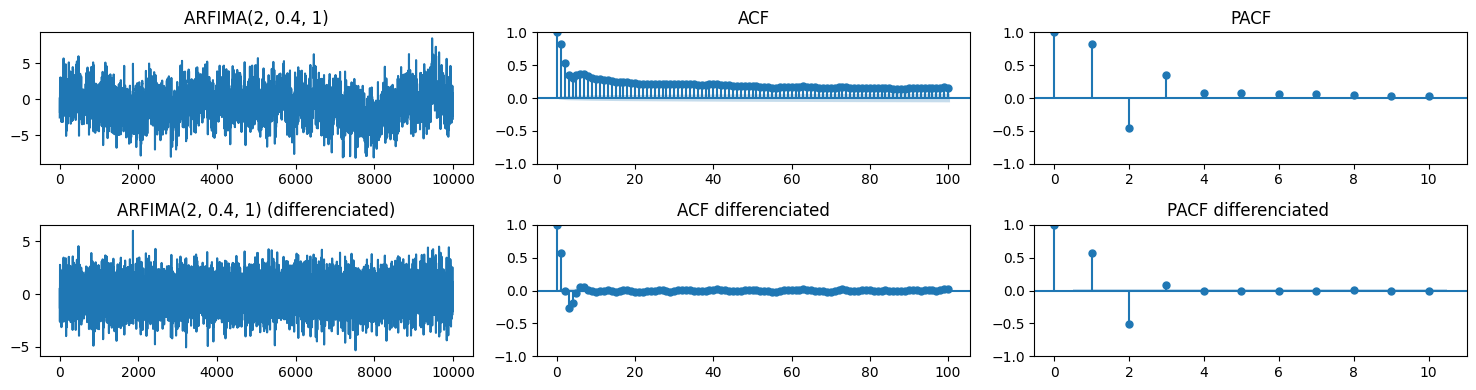

In [54]:
# On définit un ARFIMA avec un d=0.4, donc une mémoire longue plutôt importante

params = {
    'd' : 0.4,
    'n_points' : 10000,
    'ar_params' : [0.7, -0.4],
    'ma_params' : [0.2], # Coefficients used by Zhao et al. 2020
    'warmup' : 2**8,
    'noise_std' : 1,
    'noise_alpha' : 2,
    }


def define_arfima(params):
    return arfima(
        params["ar_params"],
        params["d"],
        params["ma_params"],
        params["n_points"],
        warmup = params["warmup"],
        noise_std = params["noise_std"],
        noise_alpha = params["noise_alpha"]
    )

fig, axes = plt.subplots(2, 3, figsize=(15, 4))

series = define_arfima(params)
series_d = __frac_diff(series, 0.4)

# Plot de la série

axes[0,0].plot(series)
axes[0,0].set_title(f'ARFIMA({len(params['ar_params'])}, {params['d']}, {len(params['ma_params'])})')

axes[1,0].plot(series_d)
axes[1,0].set_title(f'ARFIMA({len(params['ar_params'])}, {params['d']}, {len(params['ma_params'])}) (differenciated)')

# Plot des ACF : décroissance hyperbolique

plot_acf(series, lags=100, ax=axes[0,1])
axes[0,1].set_title('ACF')

plot_acf(series_d, lags=100, ax=axes[1,1])
axes[1,1].set_title('ACF differenciated')

# Plot des PACF

plot_pacf(series, lags=10, ax=axes[0,2])
axes[0,2].set_title('PACF')

plot_pacf(series_d, lags=10, ax=axes[1,2])
axes[1,2].set_title('PACF differenciated ')

plt.tight_layout()
plt.show()

# Benchmark G. Chevillon

## Simulation

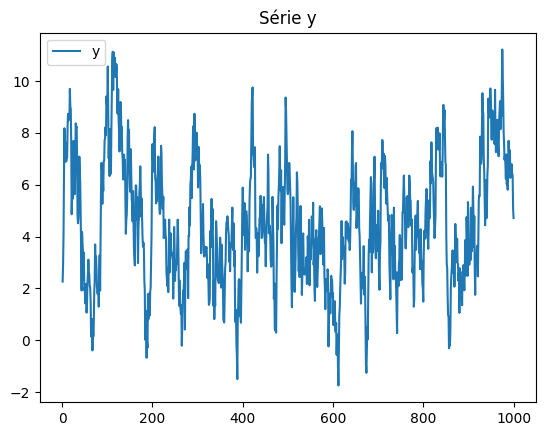

In [ ]:
def simulate_arfima(T=1000, rho=0.9, tau=0.5):
    
        # Initialisation
    np.random.seed(0)
    eps = np.random.randn(T)

        # Génération de la série AR(1) avec constante
    y = np.zeros(T)
    y[0] = tau + eps[0]
    for t in range(1, T):
        y[t] = tau + rho * y[t-1] + eps[t]

    return y

y = simulate_arfima()


def plot_arfima(y, T=1000):

        # Affichage de la série simulée
    plt.figure(0)
    plt.plot(range(1, T+1), y, label='y')
    plt.title("Série y")
    plt.legend()

plot_arfima(y)


## Prédiction

In [140]:
ARIMA(y, order=(1,0,0)).fit().params[0:2]

AutoReg(y, lags=1).fit().params

array([0.40575663, 0.91047229])

In [142]:
ARIMA(y, order=(1,0,0)).fit().params[0] / (ARIMA(y, order=(1,0,0)).fit().params[1])

np.float64(4.9262937879050375)

In [ ]:
mod_arima = ARIMA(y, order=(1,0,0)).fit()
const = mod_arima.params[0]
phi = mod_arima.params[1]
mu = const * (1 - phi)


mu

np.float64(0.40194755287627426)

In [139]:
Y = y[1:t+1]
X = np.column_stack((np.ones(t), y[0:t]))
b, _, _, _ = lstsq(X, Y, rcond=None)

b

array([0.40593004, 0.91050433])

In [137]:
def AR1fore(y, b):
    return np.dot(np.hstack(([1], y)), b)

def compute_mse(data, size):
    return np.sum(data**2) / size

def prediction_serie(y, H, model=AutoReg, lags=1, T=1000):
    T0 = int(T * 0.8)
    F = T - T0 - 1

    results = {
        "yhat": np.zeros(T-1),
        "yhat_ar": np.zeros(T-1),
        "resids": np.zeros(T-1),
        "resids_ar": np.zeros(T-1),
        "yfore": np.zeros((F, H)),
        "yfore_ar": np.zeros((F, H)),
        "errfore": np.zeros((F, H)),
        "errfore_ar": np.zeros((F, H)),
    }

    for t in range(T0, T - H):
        Y = y[1:t+1]
        X = np.column_stack((np.ones(t), y[0:t]))
        b, _, _, _ = lstsq(X, Y, rcond=None)

        if model == AutoReg:
            ar = model(Y, lags=lags).fit()
            ar_params = ar.params
        elif model == ARIMA : 
            ar = model(Y, order=lags).fit()
            ar_params = ar.params[0:2]

        

        results["yhat"][t] = AR1fore(y[t-1], b) # np.dot([1, y[t-1]], b)
        results["yhat_ar"][t] = AR1fore(y[t-1], ar_params) # np.dot([1, y[t-1]], ar_params)
        results["resids"][t] = y[t] - results["yhat"][t]
        results["resids_ar"][t] = y[t] - results["yhat_ar"][t]

        for h in range(1, H+1):
            i = t - T0
            last_y = results["yfore"][i][h-2] if h > 1 else y[t]
            last_y_ar = results["yfore_ar"][i][h-2] if h > 1 else y[t]

            results["yfore"][i][h-1] = AR1fore(last_y, b)
            results["yfore_ar"][i][h-1] = AR1fore(last_y_ar, ar_params)

            results["errfore"][i][h-1] = y[t + h] - results["yfore"][i][h-1]
            results["errfore_ar"][i][h-1] = y[t + h] - results["yfore_ar"][i][h-1]

    results["sigmahat2"] = compute_mse(results["resids"], F)
    results["sigmahat2_ar"] = compute_mse(results["resids_ar"], F)
    results["msfe"] = compute_mse(results["errfore"], F)
    results["msfe_ar"] = compute_mse(results["errfore_ar"], F)

    return results

results = prediction_serie(y, H=1, model=ARIMA, lags=(1,0,0))

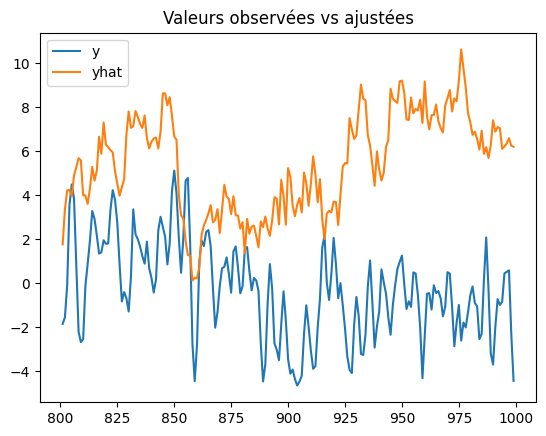

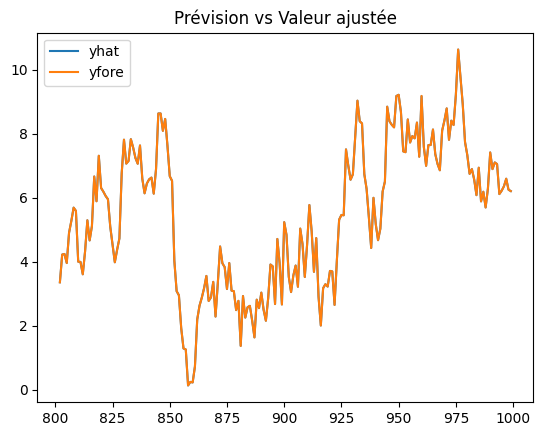

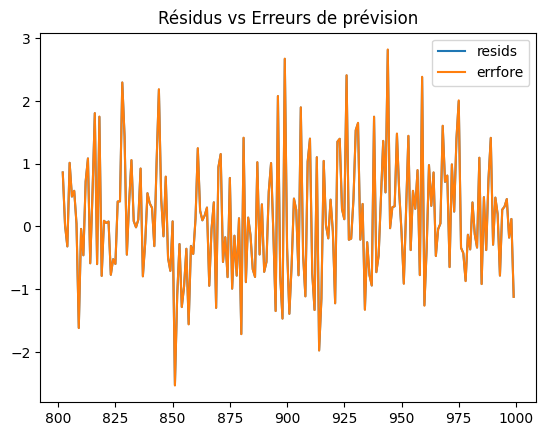

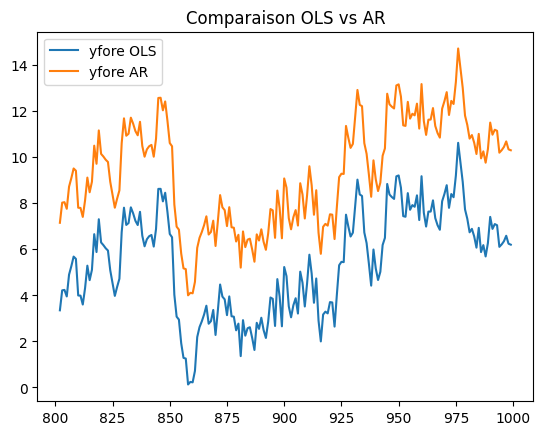

In [138]:
T = 1000
T0 = int(T * 0.8)
F = T - T0 - 1

# Graphiques
plt.figure(1)
plt.plot(range(T0+1, T), series[T0:T-1], label='y')
plt.plot(range(T0+1, T), results["yhat"][T0:T-1], label='yhat')
plt.title("Valeurs observées vs ajustées")
plt.legend()

plt.figure(2)
plt.plot(range(T0+2, T), results["yhat"][T0+1:T-1], label='yhat')
plt.plot(range(T0+2, T), results["yfore"][0:F-1, 0], label='yfore')
plt.title("Prévision vs Valeur ajustée")
plt.legend()

plt.figure(3)
plt.plot(range(T0+2, T), results["resids"][T0+1:T-1], label='resids')
plt.plot(range(T0+2, T), results["errfore"][0:F-1, 0], label='errfore')
plt.title("Résidus vs Erreurs de prévision")
plt.legend()

plt.figure(4)
plt.plot(range(T0+2, T), results["yfore"][0:F-1, 0], label='yfore OLS')
plt.plot(range(T0+2, T), results["yfore_ar"][0:F-1, 0], label='yfore AR')
plt.title("Comparaison OLS vs AR")
plt.legend()

plt.show()


## Benchmark - AR and ARMA models

### Create rolling and expanding train sequences

We define a function to create 2 types of training samples (rolling and expanding windows), to find the best balances between precision and computing time.

In [35]:
def create_sequences(data, window_size):
    r_sequences = []
    e_sequences = []
    targets = []
    for i in range(len(data) - window_size):
        r_sequences.append(data[i:i + window_size])
        e_sequences.append(data[:i + window_size])
        targets.append(data[i + window_size]) # The slicing ends at i+window_size-1
    return np.array(r_sequences), np.array(e_sequences, dtype=object), np.array(targets)

# We take a rolling window of size 9000 out of our 10000 samples

window_size = int(len(series)*0.9)

rolling_fit_d, expanding_fit_d, targets_d = create_sequences(series_d, window_size)
rolling_fit, expanding_fit, targets = create_sequences(series, window_size)

The generated series has a long-term memory ; hence by definition is non-stationary, which makes it non suitable for statistical models like AR or ARMA. We first have to differentiate the series, and then scale the series and the predictions back to the original one using fractional un differenciation.

### Differenciation

### Stationarity

In [77]:
from statsmodels.tsa.stattools import adfuller, kpss
import pandas as pd

def adf_test(timeseries):
    print("Results of Dickey-Fuller Test:")
    dftest = adfuller(timeseries, autolag="AIC")
    dfoutput = pd.Series(
        dftest[0:4],
        index=[
            "Test Statistic",
            "p-value",
            "#Lags Used",
            "Number of Observations Used",
        ],
    )
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value
    print(dfoutput)

def kpss_test(timeseries):
    print("Results of KPSS Test:")
    kpsstest = kpss(timeseries, regression="c", nlags="auto")
    kpss_output = pd.Series(
        kpsstest[0:3], index=["Test Statistic", "p-value", "Lags Used"]
    )
    for key, value in kpsstest[3].items():
        kpss_output["Critical Value (%s)" % key] = value
    print(kpss_output)

In [79]:
print(adf_test(series_d), kpss_test(series_d))

Results of Dickey-Fuller Test:
Test Statistic                  -48.827513
p-value                           0.000000
#Lags Used                        3.000000
Number of Observations Used    9996.000000
Critical Value (1%)              -3.431004
Critical Value (5%)              -2.861829
Critical Value (10%)             -2.566924
dtype: float64
Results of KPSS Test:
Test Statistic            0.070967
p-value                   0.100000
Lags Used                15.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64
None None


C:\Users\33768\AppData\Local\Temp\ipykernel_46704\4221009180.py:22: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpsstest = kpss(timeseries, regression="c", nlags="auto")


### Compute models with rollling and expanding training samples

This first benchmark aims at testing two simple models (AR and ARMA) on the series we defined earlier. We derive 4 predictions in total, one for each training set for each model. Computing time is quite long, that's why we only calculate for the first 100 values.

In [ ]:
def benchmark(lags=2, order=(2,0,1), refit = 10):

    predictions = []
    in_sample_fits = []

    for i in range(100):

        #if i % refit == 0 or i == 0 :
        rolling_ar = AutoReg(rolling_fit_d[i], lags=lags).fit()
        rolling_arima = ARIMA(rolling_fit_d[i], order=order).fit()
    
        # Predict the next step
        r_ar_pred = rolling_ar.forecast()
        r_arima_pred = rolling_arima.forecast()

        # indexing starts at 0 ; hence the last index of the series is len(fit_series[i])-1
        
        # Store the predictions and in-sample fits
        predictions.append((r_ar_pred[0], r_arima_pred[0]))
        in_sample_fits.append((rolling_ar.fittedvalues, rolling_arima.fittedvalues))

    return zip(*predictions), zip(*in_sample_fits)

(predictions, in_sample_fits) = benchmark()

rolling_ar_d, rolling_arima_d = predictions
rolling_ar, rolling_arima = __frac_diff(rolling_ar_d, -0.4), __frac_diff(rolling_arima_d, -0.4)

rolling_ar_isf, rolling_arima_isf = in_sample_fits

After some tries, we notice the forecasting for a same model and expanding or rolling window perfectly overlap ; although the *expanding window* should be more precise, the mean difference between the two is around $10^{-4}$ ; for the sake of computational power, we decide to only go with rolling window.

### Compute models with fixed training samples

In [9]:
def static_benchmark(lags=1, order=(1,0,1)):

    static_preds_man = []
    errors = [0] * order[2]
    static_ar = AutoReg(series[:window_size], lags=lags).fit()
    static_arima = ARIMA(series[:window_size], order=order).fit()

    for i in range(len(series) - window_size - lags):
        ar_input = [1] + list(series_d[window_size+i-lags : window_size+i][::-1])[:len(static_ar.params)]
        arima_ar_input = list(series_d[window_size+i-lags : window_size+i][::-1])[:len(static_arima.arparams)]
        arima_ma_input = errors[:len(static_arima.maparams)]
    
        ar_part = sum(static_arima.arparams * arima_ar_input)
        ma_part = sum(static_arima.maparams * arima_ma_input)

        static_preds_man.append((sum(static_ar.params * ar_input), ar_part + ma_part))

        error = series[window_size+i] - ar_part - ma_part
        errors = [error] + errors[:-1]
        
    return zip(*static_preds_man)

static_ar, static_arima = static_benchmark()

# static_ar, static_arima = __frac_diff(static_ar_d, -0.4), __frac_diff(static_arima_d, -0.4)

NameError: name 'window_size' is not defined

NameError: name 'static_ar' is not defined

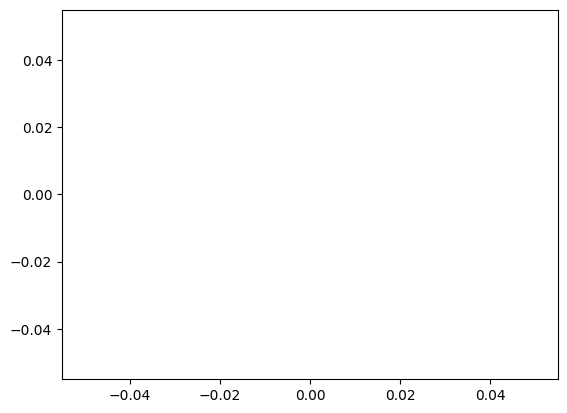

In [34]:
range = 100

plt.plot(series[window_size:range], label = 'Vraies valeurs')
plt.plot(static_ar[:range], label = 'Prédictions statiques AR')
plt.show()

Following the same logic as in Ox :

In [8]:
def static_benchmark_rolling(series, lags=1, order=(1, 0, 1)):
    T = len(series)
    T0 = int(T * 0.9)
    F = T - T0 - 1
    H = 1

    yhat_ar = np.zeros(T-1)
    yhat_arima = np.zeros(T-1)
    resids_ar = np.zeros(T-1)
    resids_arima = np.zeros(T-1)
    yfore_ar = np.zeros((F, H))
    yfore_arima = np.zeros((F, H))
    errfore_ar = np.zeros((F, H))
    errfore_arima = np.zeros((F, H))

    

    for t in range(T0, T - H):
        # Fit AR and ARIMA on expanding window
        ar_model = AutoReg(series[:t+1], lags=lags).fit()
        arima_model = ARIMA(series[:t+1], order=order).fit()


        # In-sample prediction (last value of training)
        X_ar = np.array([1] + list(series[t - lags + 1: t + 1][::-1])[:len(ar_model.params)])
        yhat_ar[t] = np.dot(ar_model.params, X_ar)
        resids_ar[t] = series[t] - yhat_ar[t]

        ar_input = list(series[t - len(arima_model.arparams) + 1: t + 1][::-1])
        ma_input = arima_model.resid[-len(arima_model.maparams):][::-1]
        ar_part = np.dot(arima_model.arparams, np.array(ar_input))
        ma_part = np.dot(arima_model.maparams, np.array(ma_input))
        yhat_arima[t] = ar_part + ma_part
        resids_arima[t] = series[t] - yhat_arima[t]

        # 1-step ahead forecast
        X_future = list(series[max(0, t - lags + 1): t + 1][::-1])
        X_future = [1] + X_future
        yfore_ar[t - T0][0] = np.dot(ar_model.params, X_future)

        # Inputs AR
        p = len(arima_model.arparams)
        ar_input_fore = list(series[max(0, t - p + 1): t + 1][::-1])
        if len(ar_input_fore) < p:
            ar_input_fore += [0.0] * (p - len(ar_input_fore))

        # Inputs MA
        q = len(arima_model.maparams)
        ma_input_fore = list(arima_model.resid[-(q-1):][::-1]) + [resids_arima[t]]
        if len(ma_input_fore) < q:
            ma_input_fore += [0.0] * (q - len(ma_input_fore))
        else:
            ma_input_fore = ma_input_fore[:q]

        # Prédiction
        ar_part_fore = np.dot(arima_model.arparams, ar_input_fore)
        ma_part_fore = np.dot(arima_model.maparams, ma_input_fore)

        yfore_arima[t - T0][0] = ar_part_fore + ma_part_fore

        errfore_ar[t - T0][0] = series[t + 1] - yfore_ar[t - T0][0]
        errfore_arima[t - T0][0] = series[t + 1] - yfore_arima[t - T0][0]

    return yhat_ar, yhat_arima, yfore_ar, yfore_arima, resids_ar, resids_arima, errfore_ar, errfore_arima

yhat_ar, yhat_arima, yfore_ar, yfore_arima, resids_ar, resids_arima, errfore_ar, errfore_arima = [static_benchmark_rolling(series)[i] for i in range(8)]


KeyboardInterrupt: 

In [ ]:
# Graphiques
plt.figure(1)
plt.plot(range(T0+1, T), series[T0:T-1], label='y')
plt.plot(range(T0+1, T), yhat_ar[T0:T-1], label='yhat_AR')
plt.plot(range(T0+1, T), yhat_arima[T0:T-1], label='yhat_ARIMA')
plt.title("Valeurs observées vs ajustées")
plt.legend()

plt.figure(2)
plt.plot(range(T0+1, T), yhat_ar[T0:T-1], label='yhat_AR')
plt.plot(range(T0+1, T), yfore_ar[:, 0], label='yfore_AR')
plt.plot(range(T0+1, T), yfore_arima[:, 0], label='yfore_ARIMA')
plt.title("Prévision vs Valeur ajustée")
plt.legend()

plt.figure(3)
plt.plot(range(T0+1, T), resids_ar[T0:T-1], label='resids_AR')
plt.plot(range(T0+1, T), resids_arima[T0:T-1], label='resids_ARIMA')
plt.plot(range(T0+1, T), errfore_ar[:, 0], label='errfore_AR')
plt.plot(range(T0+1, T), errfore_arima[:, 0], label='errfore_ARIMA')
plt.title("Résidus vs Erreurs de prévision")
plt.legend()

plt.show()

### Compute models with prediction-added training samples

We try making the one-step-ahead prediction by using the previous one as input, and appending the prediction to the training set.

In [44]:
def predictions_benchmark(series, window_size=9000, lags=2, order=(2, 0, 1)):
    appended_preds = []

    training_sample_ar = series[:window_size].tolist()
    training_sample_arima = series[:window_size].tolist()

    for _ in range(100): 
        # Fit models on current training data
          # if i % 10 == 0:
        appended_ar = AutoReg(training_sample_ar, lags=lags).fit()
        appended_arima = ARIMA(training_sample_arima, order=order).fit()

        # Predict next value
        ar_pred = appended_ar.forecast()
        arima_pred = appended_arima.forecast()

        # Append predictions to the training samples
        training_sample_ar.append(ar_pred[0])
        training_sample_arima.append(arima_pred[0])

        # Store predictions
        appended_preds.append((ar_pred[0], arima_pred[0]))

    return zip(*appended_preds)

appended_ar, appended_arima = predictions_benchmark(series)


### Visualisation

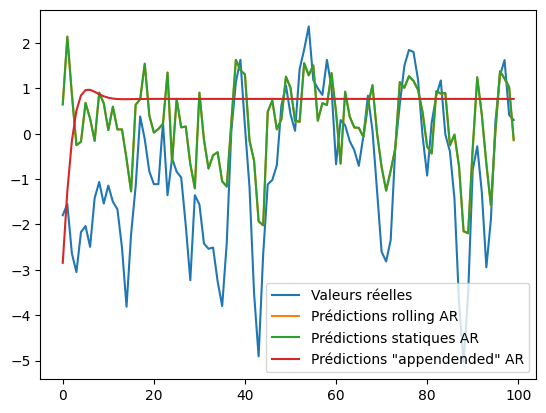

In [46]:
def plot_predictions(range=100):

    targets = series[window_size:]

    plt.plot(targets[:range], label = 'Valeurs réelles')

    plt.plot(rolling_ar[:range], label = 'Prédictions rolling AR')
    #plt.plot(rolling_arima[:range], label = 'Prédictions rolling ARIMA')

    plt.plot(static_ar[:range], label = 'Prédictions statiques AR')
    #plt.plot(static_arima[:range], label = 'Prédictions statiques ARIMA')

    plt.plot(appended_ar[:range], label = 'Prédictions "appendended" AR')
    #plt.plot(appended_arima[:range], label = 'Prédictions "appendended" ARIMA')
    plt.legend()
    plt.show()

plot_predictions()


# Some series visually perfectly overlap ; the estimated coefficients between rolling and expanding windows are very similar.

### In-sample analysis

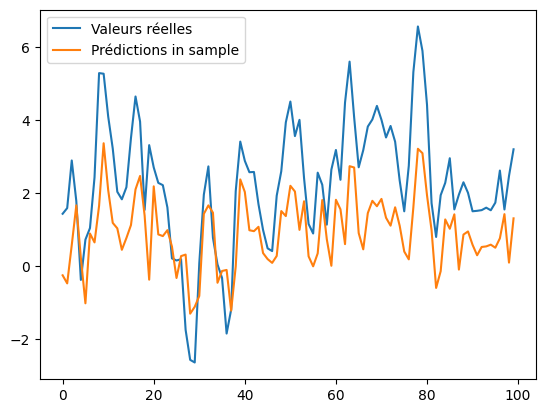

In [76]:
def plot_isf(): 
    plt.plot(rolling_fit[0][2:102], label = 'Valeurs réelles')
    plt.plot(__frac_diff(rolling_ar_isf, -0.4)[0][:100], label = 'Prédictions in sample')
    #plt.plot(expanding_ar_isf[0][1:100], label = 'Prédictions expanding AR')
    #plt.plot(rolling_arima_isf[1:100], label = 'Prédictions rolling ARIMA')
    #plt.plot(expanding_arima_isf[1:100], label = 'Prédictions expanding ARIMA')
    plt.legend()
    plt.show()

plot_isf()

### ACF and PACF predictions

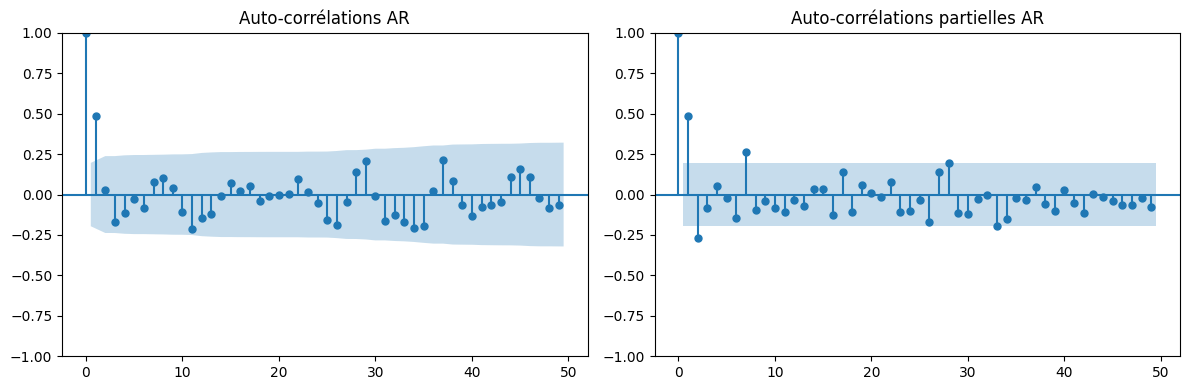

In [71]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

plot_acf(rolling_ar, lags=49, ax=axes[0])
axes[0].set_title('Auto-corrélations AR')

plot_pacf(rolling_ar, lags=49, ax=axes[1])
axes[1].set_title('Auto-corrélations partielles AR')

plt.tight_layout()
plt.show()

# LSTM

## Découpage de l'échantillon pour LSTM

In [ ]:
def create_sequences(data, window_size):
    sequences = []
    targets = []
    for i in range(len(data) - window_size - 1):
        sequences.append(data[i:i + window_size])
        targets.append(data[i + window_size + 1])
    return np.array(sequences), np.array(targets)


window_size = 9000  # Taille de la fenêtre
expanding_sequences, train_targets = create_sequences(series, window_size)
expanding_sequences, test_targets = create_sequences(series, window_size)

In [ ]:
# Normalization of the inputs

train_sequences_n = []
train_targets_n = []
test_sequences_n = []
test_targets_n = []

for i in range(len(train_sequences)):
    train_sequences_n.append((train_sequences[i] - train_sequences[i].mean()) / train_sequences[i].std())
    train_targets_n.append((train_targets[i] - train_sequences[i].mean()) / train_sequences[i].std())

for i in range(len(test_sequences)):
    test_sequences_n.append((test_sequences[i] - test_sequences[i].mean()) / test_sequences[i].std())
    test_targets_n.append((test_targets[i] - test_sequences[i].mean()) / test_sequences[i].std())

train_sequences_n = np.array(train_sequences_n)
train_targets_n = np.array(train_targets_n)
test_sequences_n = np.array(test_sequences_n)
test_targets_n = np.array(test_targets_n)

In [ ]:
# Reshape des échantillons pour l'entrée dans le LSTM

train_sequences_n = train_sequences_n.reshape((train_sequences_n.shape[0], window_size, 1))
test_sequences_n = test_sequences_n.reshape((test_sequences_n.shape[0], window_size, 1))

train_sequences = train_sequences.reshape((train_sequences.shape[0], window_size, 1))
test_sequences = test_sequences.reshape((test_sequences.shape[0], window_size, 1))

In [ ]:
# Vérification des formats d'entraînement 

print(f'Train shape : {train_sequences.shape}, test shape : {test_sequences.shape}')
print(f'Train target shape : {train_targets.shape}, test target shape : {test_targets.shape}')

Train shape : (8899, 100, 1), test shape : (899, 100, 1)
Train target shape : (8899,), test target shape : (899,)


## Modèle LSTM baseline

In [ ]:
# Simple model

model_baseline = tf.keras.Sequential([
    tf.keras.layers.LSTM(100, return_sequences=True, input_shape=(window_size,1)), # WIndow size is 100
    tf.keras.layers.LSTM(50, activation='relu'), # Penultimate layer should be a LSTM
    tf.keras.layers.Dense(1)
])

# Compile the model with Adagrad optimizer and mean absolute error loss
model_baseline.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mean_squared_error')

c:\Users\33768\AppData\Local\pypoetry\Cache\virtualenvs\lstms-b3l13L35-py3.12\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_15 (LSTM)                  │ (None, 100, 100)       │        40,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_16 (LSTM)                  │ (None, 50)             │        30,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 71,051 (277.54 KB)

 Trainable params: 71,051 (277.54 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Fit the model

model_baseline.fit(train_sequences, train_targets, batch_size=100, epochs=10)

predictions = model_baseline.predict(test_sequences)

Epoch 1/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 23s 206ms/step - loss: 14.5162
Epoch 2/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 17s 194ms/step - loss: 10.2479
Epoch 3/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 17s 186ms/step - loss: 1.3575
Epoch 4/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 17s 190ms/step - loss: 1.4264
Epoch 5/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 16s 178ms/step - loss: 1.3324
Epoch 6/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 16s 178ms/step - loss: 1.2985
Epoch 7/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 16s 175ms/step - loss: 1.2949
Epoch 8/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 16s 182ms/step - loss: 1.2203
Epoch 9/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 16s 176ms/step - loss: 1.1749
Epoch 10/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 15s 173ms/step - loss: 1.1728
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step


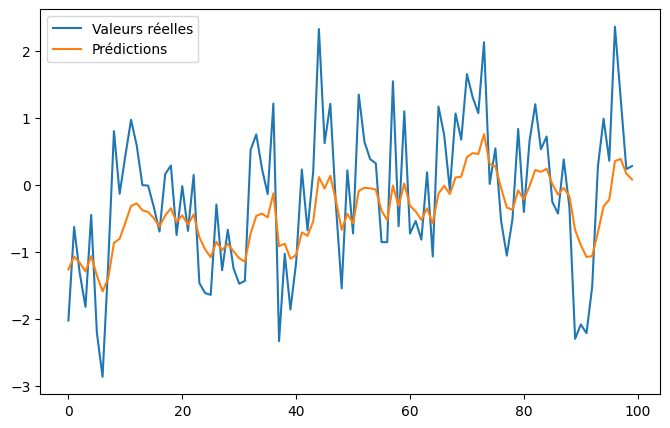

In [ ]:
# Plot the prediction results versus true values

plt.figure(figsize=(8, 5))
plt.plot(range(100), test_targets[:100], label='Valeurs réelles')
plt.plot(range(100), predictions[2:102], label='Prédictions')
# Can't understand for now why are the predictions shifted for 2 units but it seems to be the case
plt.legend()
plt.show()

### Corrections attempt

In [ ]:
# Predictions are quite flat ; quick and dirty attempt to make them match closer to the target

def amplif(list):

    new_list = [list[0]]

    for i in range(len(list)-1):
        if list[i+1] > list[i]:
            new_list.append(list[i+1]*2)
        else : new_list.append(list[i+1]/2)

    return new_list


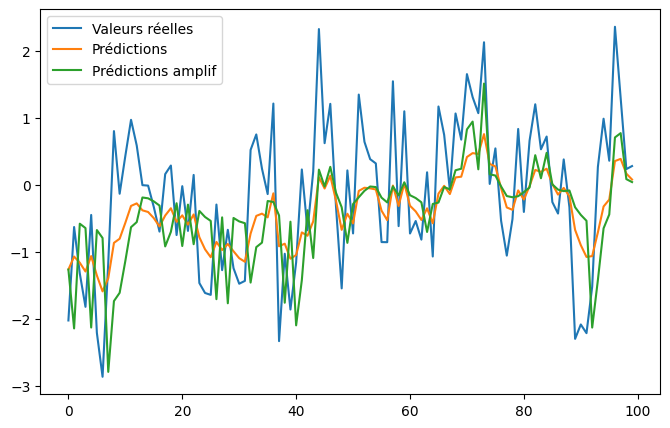

In [ ]:
plt.figure(figsize=(8, 5))
plt.plot(range(100), test_targets[:100], label='Valeurs réelles')
plt.plot(range(100), predictions[2:102], label='Prédictions')
plt.plot(range(100), amplif(predictions[2:102]), label='Prédictions amplif')
plt.legend()
plt.show()

# Works more or less as long as there is not too much variation on the data

In [ ]:
# Working good on the 50 first samples for example :

score_pred = np.sqrt(np.mean(((test_targets[0:] - predictions[2:])**2)))
score_amplif = np.sqrt(np.mean(((test_targets[0:] - amplif(predictions[2:]))**2)))

print(f'Base score on first samples : {round(score_pred,2)}, versus amplified results : {round(score_amplif,2)}')

Base score on first samples : 1.66, versus amplified results : 1.87


### In / out of sample

In [ ]:
# Predict on the training data (in-sample fit)
in_sample_predictions = model_baseline.predict(train_sequences)

In [ ]:
# Compute residuals and their variance
residuals = train_targets[:-2] - in_sample_predictions.flatten()[2:]
variance_residuals = np.var(residuals)

# out_of_sample_predictions = model_baseline.predict(test_sequences)
rmse_out_of_sample = np.sqrt(np.mean((test_targets[:-2] - (predictions).flatten()[2:])**2))

# Print the results
print(f"Variance of residuals (in-sample): {variance_residuals}")
print(f"RMSE (out-of-sample): {rmse_out_of_sample}")

Variance of residuals (in-sample): 0.6103329754774233
RMSE (out-of-sample): 0.8329516160081273


In [ ]:
# We observe a significant biais in the training data

print(f'Mean difference between train and in-sample prediction : {round(np.mean(train_targets) - np.mean(in_sample_predictions),2)}')

Mean difference between train and in-sample prediction : 0.19


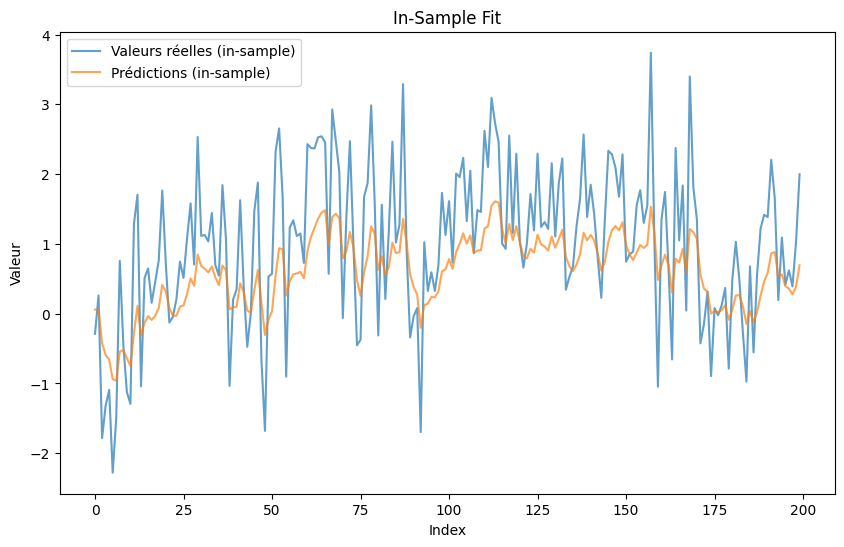

In [ ]:
# Plot the in-sample fit
plt.figure(figsize=(10, 6))
plt.plot(train_targets[:200], label='Valeurs réelles (in-sample)', alpha=0.7)
plt.plot(in_sample_predictions[2:202], label='Prédictions (in-sample)', alpha=0.7)
plt.title("In-Sample Fit")
plt.xlabel("Index")
plt.ylabel("Valeur")
plt.legend()
plt.show()

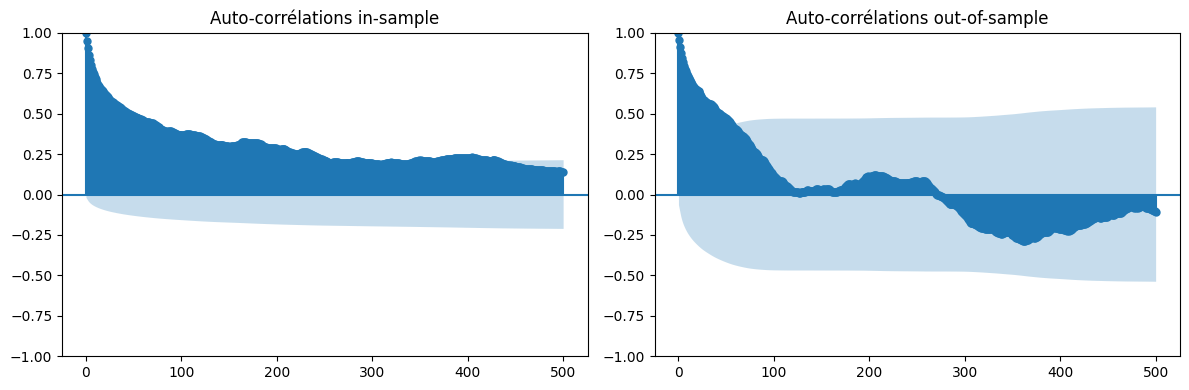

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

plot_acf(in_sample_predictions, lags=500, ax=axes[0])
axes[0].set_title('Auto-corrélations in-sample')

plot_acf(predictions, lags=500, ax=axes[1])
axes[1].set_title('Auto-corrélations out-of-sample')

plt.tight_layout()
plt.show()

## Improvement of the previous model

In [ ]:
# Simple model bettered

model_baseline_2 = tf.keras.Sequential([
    tf.keras.layers.LSTM(100, return_sequences=True, input_shape=(window_size,1)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.LSTM(100, return_sequences=True),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.LSTM(50, activation='relu', kernel_regularizer=tf.keras.regularizers.l1(0.01)),
    tf.keras.layers.Dense(1, kernel_regularizer=tf.keras.regularizers.l1(0.01))
])

model_baseline_2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mean_squared_error')

model_baseline_2.summary()

c:\Users\33768\AppData\Local\pypoetry\Cache\virtualenvs\lstms-b3l13L35-py3.12\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_17 (LSTM)                  │ (None, 100, 100)       │        40,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 100, 100)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_18 (LSTM)                  │ (None, 100, 100)       │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 100, 100)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_19 (LSTM)                  │ (None, 50)             │        30,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 151,451 (591.61 KB)

 Trainable params: 151,451 (591.61 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Fit the model with early stopping on the train series

model_baseline_2.fit(train_sequences, train_targets, batch_size=100, epochs=10)

predictions_2 = model_baseline_2.predict(test_sequences)

Epoch 1/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 44s 406ms/step - loss: 12.0048
Epoch 2/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 33s 372ms/step - loss: 2.6917
Epoch 3/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 32s 358ms/step - loss: 1.4746
Epoch 4/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 32s 361ms/step - loss: 1.6218
Epoch 5/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 32s 362ms/step - loss: 1.3813
Epoch 6/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 32s 357ms/step - loss: 1.3187
Epoch 7/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 32s 362ms/step - loss: 1.3021
Epoch 8/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 32s 359ms/step - loss: 1.2985
Epoch 9/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 32s 363ms/step - loss: 1.3127
Epoch 10/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 32s 361ms/step - loss: 1.2878
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 79ms/step


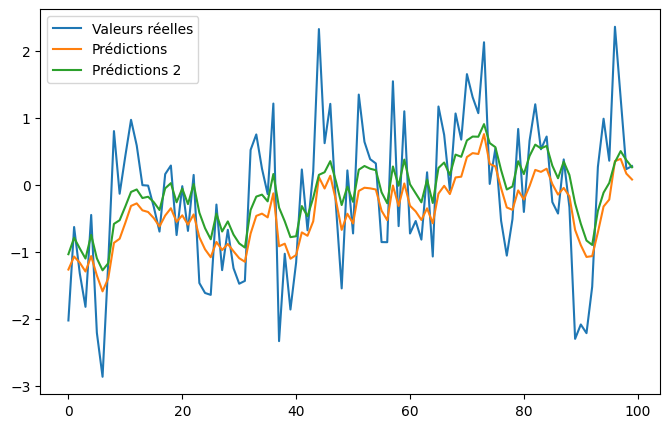

In [ ]:
# Plot the prediction results versus true values

plt.figure(figsize=(8, 5))
plt.plot(range(100), test_targets[:100], label='Valeurs réelles')
plt.plot(range(100), predictions[2:102], label='Prédictions')
plt.plot(range(100), predictions_2[2:102], label='Prédictions 2')
plt.legend()
plt.show()

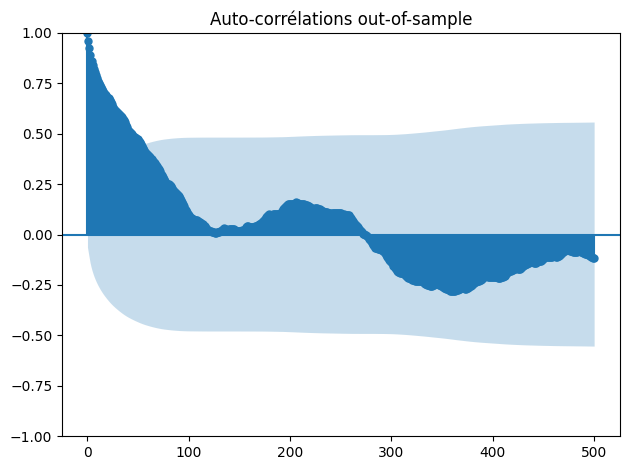

In [ ]:
plot_acf(predictions_2, lags=500)
plt.title('Auto-corrélations out-of-sample')

plt.tight_layout()
plt.show()

In [ ]:
score_pred_2 = (test_targets[:100] - predictions_2[2:102]).mean() # regarder les erreurs en valeur absolue

print(f'Base score on first samples : {round(score_pred,3)}, versus amplified results : {round(score_amplif,3)}, and model 2 : {round(score_pred_2,3)}')

Base score on first samples : -0.129, versus amplified results : -0.144, and model 2 : -0.198


## CNN tentative

In [ ]:
# Taken from https://www.kaggle.com/code/davidchilders/time-series-prediction-in-r-keras/notebook


# Define the Sequential model
crmodel2 = tf.keras.Sequential()

# Add layers
crmodel2.add(layers.Conv1D(
    filters=32,
    kernel_size=1,
    kernel_regularizer=regularizers.l1(0.001),
    activation='relu',
    input_shape=(1, 1)
))
crmodel2.add(layers.MaxPooling1D(pool_size=1))
crmodel2.add(layers.Conv1D(
    filters=32,
    kernel_size=1,
    kernel_regularizer=regularizers.l1(0.001),
    activation='relu'
))
crmodel2.add(layers.GRU(
    units=32,
    kernel_regularizer=regularizers.l1(0.001),
    dropout=0.1,
    recurrent_dropout=0.5
))
crmodel2.add(layers.Dense(units=1))

# Display the model's architecture
crmodel2.summary()

# Compile the model
crmodel2.compile(
    optimizer='rmsprop',
    loss='mse'
)

# Train the model
crhistory2 = crmodel2.fit(
    train_sequences,
    train_targets,
    steps_per_epoch=47,
    epochs=10
)

predictions_cnn =  crmodel2.predict(test_sequences)


c:\Users\33768\AppData\Local\pypoetry\Cache\virtualenvs\lstms-b3l13L35-py3.12\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 1, 32)          │            64 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 1, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 1, 32)          │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, 32)             │         6,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,489 (29.25 KB)

 Trainable params: 7,489 (29.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 7s 58ms/step - loss: 2.1005
Epoch 2/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - loss: 1.5549
Epoch 3/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step - loss: 1.4722
Epoch 4/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step - loss: 1.3861
Epoch 5/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step - loss: 1.3031
Epoch 6/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - loss: 1.3210
Epoch 7/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - loss: 1.2814
Epoch 8/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step - loss: 1.2724
Epoch 9/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step - loss: 1.2795
Epoch 10/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 62ms/step - loss: 1.2963


29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step


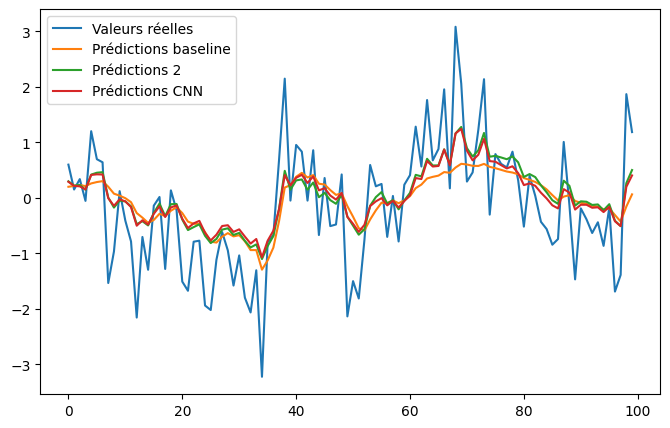

In [ ]:
# Plot the prediction results versus true values

plt.figure(figsize=(8, 5))
plt.plot(range(100), test_targets[:100], label='Valeurs réelles')
plt.plot(range(100), predictions[2:102], label='Prédictions baseline')
plt.plot(range(100), predictions_2[2:102], label='Prédictions 2')
plt.plot(range(100), predictions_cnn[2:102], label='Prédictions CNN')
plt.legend()
plt.show()

## Comparison between models

In [ ]:
score_baseline = (test_targets - predictions).mean()
score_baseline_2 = (test_targets - predictions_2).mean()
score_baseline_cnn = (test_targets - predictions_cnn).mean()

print(f'MAE on baseline : {round(score_baseline,3)}, MAE baseline 2 : {round(score_baseline_2,3)}, MAE CNN : {round(score_baseline_cnn,3)}')

MAE on baseline : -0.018, MAE baseline 2 : -0.144, MAE CNN : -0.1


# mRNN - mLSTM

In [ ]:
import mRNN_mLSTM.time_series_prediction.train as train
import importlib

importlib.reload(train)
rmse, values, predictions = train.train_model(dataset=define_arfima(), epochs=5, start=0, end=3)

c:\Users\33768\AppData\Local\pypoetry\Cache\virtualenvs\lstms-b3l13L35-py3.12\Lib\site-packages\torch\nn\modules\loss.py:610: UserWarning: Using a target size (torch.Size([2000, 1, 1])) that is different to the input size (torch.Size([2000, 1, 100])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\33768\AppData\Local\pypoetry\Cache\virtualenvs\lstms-b3l13L35-py3.12\Lib\site-packages\torch\nn\modules\loss.py:610: UserWarning: Using a target size (torch.Size([6000, 1, 1])) that is different to the input size (torch.Size([6000, 1, 100])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


epoch:  0 train_loss: 0.70050 val_loss: 0.53193  time: 7.2s
epoch:  1 train_loss: 0.68520 val_loss: 0.51866  time: 7.7s
epoch:  2 train_loss: 0.67004 val_loss: 0.50554  time: 7.7s
epoch:  3 train_loss: 0.65502 val_loss: 0.49259  time: 8.0s
epoch:  4 train_loss: 0.64015 val_loss: 0.47982  time: 7.6s
RMSE:[31.40386950072294]
MAE:[30.29631775403902]


c:\Users\33768\AppData\Local\pypoetry\Cache\virtualenvs\lstms-b3l13L35-py3.12\Lib\site-packages\torch\nn\modules\loss.py:610: UserWarning: Using a target size (torch.Size([2000, 1, 1])) that is different to the input size (torch.Size([2000, 1, 100])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\33768\AppData\Local\pypoetry\Cache\virtualenvs\lstms-b3l13L35-py3.12\Lib\site-packages\torch\nn\modules\loss.py:610: UserWarning: Using a target size (torch.Size([6000, 1, 1])) that is different to the input size (torch.Size([6000, 1, 100])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


epoch:  0 train_loss: 0.64690 val_loss: 0.50226  time: 7.6s
epoch:  1 train_loss: 0.63346 val_loss: 0.49059  time: 8.0s
epoch:  2 train_loss: 0.62009 val_loss: 0.47908  time: 6.9s
epoch:  3 train_loss: 0.60680 val_loss: 0.46770  time: 7.0s
epoch:  4 train_loss: 0.59358 val_loss: 0.45644  time: 6.8s
RMSE:[31.40386950072294, 1.0578344054732773]
MAE:[30.29631775403902, 1.0474027480286465]


c:\Users\33768\AppData\Local\pypoetry\Cache\virtualenvs\lstms-b3l13L35-py3.12\Lib\site-packages\torch\nn\modules\loss.py:610: UserWarning: Using a target size (torch.Size([2000, 1, 1])) that is different to the input size (torch.Size([2000, 1, 100])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\33768\AppData\Local\pypoetry\Cache\virtualenvs\lstms-b3l13L35-py3.12\Lib\site-packages\torch\nn\modules\loss.py:610: UserWarning: Using a target size (torch.Size([6000, 1, 1])) that is different to the input size (torch.Size([6000, 1, 100])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


epoch:  0 train_loss: 0.74601 val_loss: 0.57416  time: 7.7s
epoch:  1 train_loss: 0.73091 val_loss: 0.56108  time: 8.0s
epoch:  2 train_loss: 0.71592 val_loss: 0.54815  time: 8.8s
epoch:  3 train_loss: 0.70105 val_loss: 0.53537  time: 8.7s
epoch:  4 train_loss: 0.68629 val_loss: 0.52273  time: 7.6s
RMSE:[31.40386950072294, 1.0578344054732773, 0.350967937589927]
MAE:[30.29631775403902, 1.0474027480286465, 0.32586313783593773]


In [ ]:
predictions

[array([[ 19.66135  ,   4.851437 , -80.8341   , ..., -28.854063 ,
         -47.617203 , -19.608082 ],
        [ 19.686417 ,   4.8662724, -80.833565 , ..., -28.835245 ,
         -47.639446 , -19.581118 ],
        [ 19.728168 ,   4.890981 , -80.83267  , ..., -28.803904 ,
         -47.676495 , -19.53621  ],
        ...,
        [ 19.951408 ,   5.0230913, -80.8279   , ..., -28.636312 ,
         -47.874596 , -19.296074 ],
        [ 20.00559  ,   5.055157 , -80.826744 , ..., -28.595636 ,
         -47.922676 , -19.23779  ],
        [ 20.050528 ,   5.0817494, -80.82579  , ..., -28.561901 ,
         -47.96255  , -19.189451 ]], dtype=float32),
 array([[-0.63588494,  0.17342104,  0.68751085, ...,  0.23458889,
          0.40685654, -0.7840899 ],
        [-0.63446707,  0.17351587,  0.68808997, ...,  0.23303628,
          0.40352792, -0.7882587 ],
        [-0.63226014,  0.17366347,  0.68899125, ...,  0.23061965,
          0.39834696, -0.7947472 ],
        ...,
        [-0.62148637,  0.174384  ,  0.6

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from copy import deepcopy
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import math
import time
from sklearn.metrics import mean_squared_error, mean_absolute_error
from mRNN_mLSTM.time_series_prediction.utils import create_dataset, to_torch
from mRNN_mLSTM.time_series_prediction import models 


dataset = define_arfima()
train_size = int(3*len(dataset)/5)
validate_size = int(len(dataset)/5)
rmse_list = []
mae_list = []
value_list = []
predictions_list = []
batch_size = 1
start = 0
end = 2
algorithm = 'MLSTMFixD' 
lr = 0.01 
epochs = 1
input_size = 1
hidden_size = 1
output_size = 1
K = 100
patience = 100

dataset = dataset.reshape(-1, 1)
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
# use this function to prepare the dataset for modeling
X, Y = create_dataset(dataset, look_back=100)

# split into train and test sets
train_x, train_y = X[0:train_size], Y[0:train_size]
validate_x, validate_y = X[train_size:train_size + validate_size], Y[train_size:train_size + validate_size]
test_x, test_y = X[train_size + validate_size:len(Y)], Y[train_size + validate_size:len(Y)]

# reshape input to be [time steps,samples,features]
train_x = np.reshape(train_x, (train_x.shape[0], batch_size, input_size))
validate_x = np.reshape(validate_x, (validate_x.shape[0], batch_size , input_size))
test_x = np.reshape(test_x, (test_x.shape[0], batch_size, input_size))
train_y = np.reshape(train_y, (train_y.shape[0], batch_size, output_size))
validate_y = np.reshape(validate_y, (validate_y.shape[0], batch_size, output_size))
test_y = np.reshape(test_y, (test_y.shape[0], batch_size, output_size))


In [ ]:
define_arfima()

array([-0.51660917, -2.17332796, -0.41077277, ...,  0.46407444,
        1.44306834,  1.13885366])

In [ ]:
from mRNN_mLSTM.time_series_prediction import models 

model = models.MRNNFixD(input_size, hidden_size, output_size, K)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=lr)
best_loss = np.inf
best_train_loss = np.inf
stop_criterion = 1e-5
rec = np.zeros((epochs, 3))
epoch = 0
val_loss = -1
train_loss = -1
cnt = 0

def train():
    model.train()
    optimizer.zero_grad()
    target = torch.from_numpy(train_y).float()
    output, hx = model(torch.from_numpy(train_x).float())
    with torch.no_grad():
        val_y, _ = model(torch.from_numpy(validate_x).float(), hx)
        target_val = torch.from_numpy(validate_y).float()
        val_loss = criterion(val_y, target_val)

    loss = criterion(output, target)
    loss.backward()
    optimizer.step()
    return loss, val_loss

In [ ]:

def compute_test(best_model):
    model = best_model
    train_predict, hx = model(to_torch(train_x))
    train_predict = train_predict.detach().numpy()
    val_predict, hx = model(to_torch(validate_x), hx)
    test_predict, _ = model(to_torch(test_x), hx)
    test_predict = test_predict.detach().numpy()
    # invert predictions
    test_predict_r = scaler.inverse_transform(test_predict[:, 0, :])
    test_y_r = scaler.inverse_transform(test_y[:, 0, :])
    # calculate error
    test_rmse = math.sqrt(mean_squared_error(test_y_r[:, 0], test_predict_r[:, 0]))
    test_mape = (abs((test_predict_r[:, 0] - test_y_r[:, 0]) / test_y_r[:, 0])).mean()
    test_mae = mean_absolute_error(test_predict_r[:, 0], test_y_r[:, 0])
    return test_rmse, test_mape, test_mae, test_y_r, test_predict_r


In [ ]:
test_predict, _ = model(to_torch(test_x), hx)
test_predict = np.reshape(test_predict.detach().numpy(), (test_predict.detach().numpy().shape[0], batch_size, output_size))
test_predict_r = scaler.inverse_transform(test_predict[:, 0, :])

test_y[:, 0, :]

array([[0.26434106],
       [0.33303069],
       [0.38740319],
       ...,
       [0.52372522],
       [0.46603094],
       [0.33491738]])

In [ ]:

while epoch < epochs:
    _time = time.time()
    loss, val_loss = train()
    if (val_loss < best_loss):
        best_loss = val_loss
        best_epoch = epoch
        best_model = deepcopy(model)
    # stop_criteria = abs(criterion(val_Y, target_val) - val_loss)
    if ((best_train_loss - loss) > stop_criterion):
        best_train_loss = loss
        cnt = 0
    else:
        cnt += 1
    if cnt == patience:
        break
    # save training records
    time_elapsed = time.time()-_time
    rec[epoch, :] = np.array([loss.detach().numpy(), val_loss.detach().numpy(), time_elapsed])
    print("epoch: {:2.0f} train_loss: {:2.5f} val_loss: {:2.5f}  time: {:2.1f}s".format(
        epoch, loss.item(), val_loss.item(), time_elapsed))
    epoch = epoch + 1

# make predictions
test_rmse, test_mape, test_mae, test_y_r, test_predict_r = compute_test(best_model)

rmse_list.append(test_rmse)
mae_list.append(test_mae)
value_list.append(test_y_r)
predictions_list.append(test_predict_r)
print('RMSE:{}'.format(rmse_list))
print('MAE:{}'.format(mae_list))
